In [1]:
import os
import sys
import itertools
import math
import logging 
import json
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

In [2]:
import cv2
import matplotlib.pyplot as plt
import time
from PIL import Image


In [3]:
labels = open("../input/yolo-coco-data/coco.names").read().strip().split('\n')

In [4]:
labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [5]:
weights_path = '../input/yolo-coco-data/yolov3.weights'
confuigration = '../input/yolo-coco-data/yolov3.cfg'

In [6]:
probability_minimum = 0.5
threshold = 0.3
network = cv2.dnn.readNetFromDarknet(confuigration, weights_path)
layers_names_all = network.getLayerNames()

In [7]:
layers_names_all

('conv_0',
 'bn_0',
 'leaky_1',
 'conv_1',
 'bn_1',
 'leaky_2',
 'conv_2',
 'bn_2',
 'leaky_3',
 'conv_3',
 'bn_3',
 'leaky_4',
 'shortcut_4',
 'conv_5',
 'bn_5',
 'leaky_6',
 'conv_6',
 'bn_6',
 'leaky_7',
 'conv_7',
 'bn_7',
 'leaky_8',
 'shortcut_8',
 'conv_9',
 'bn_9',
 'leaky_10',
 'conv_10',
 'bn_10',
 'leaky_11',
 'shortcut_11',
 'conv_12',
 'bn_12',
 'leaky_13',
 'conv_13',
 'bn_13',
 'leaky_14',
 'conv_14',
 'bn_14',
 'leaky_15',
 'shortcut_15',
 'conv_16',
 'bn_16',
 'leaky_17',
 'conv_17',
 'bn_17',
 'leaky_18',
 'shortcut_18',
 'conv_19',
 'bn_19',
 'leaky_20',
 'conv_20',
 'bn_20',
 'leaky_21',
 'shortcut_21',
 'conv_22',
 'bn_22',
 'leaky_23',
 'conv_23',
 'bn_23',
 'leaky_24',
 'shortcut_24',
 'conv_25',
 'bn_25',
 'leaky_26',
 'conv_26',
 'bn_26',
 'leaky_27',
 'shortcut_27',
 'conv_28',
 'bn_28',
 'leaky_29',
 'conv_29',
 'bn_29',
 'leaky_30',
 'shortcut_30',
 'conv_31',
 'bn_31',
 'leaky_32',
 'conv_32',
 'bn_32',
 'leaky_33',
 'shortcut_33',
 'conv_34',
 'bn_34',
 'l

In [8]:
layers_names_output = [layers_names_all[i-1] for i in network.getUnconnectedOutLayers()]
print(layers_names_output)

['yolo_82', 'yolo_94', 'yolo_106']


In [9]:
image_input = cv2.imread("../input/car-damage-detection/data1a/training/00-damage/0001.JPEG")
image_input_shape = image_input.shape

In [10]:
image_input_shape

(168, 300, 3)

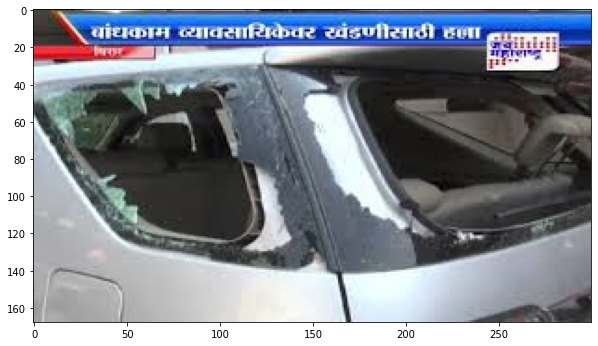

In [11]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
blob = cv2.dnn.blobFromImage(image_input, 1/255.0, (416, 416), swapRB=True, crop=False)
print(image_input.shape)
print(blob.shape)

(168, 300, 3)
(1, 3, 416, 416)


In [13]:
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)

(416, 416, 3)


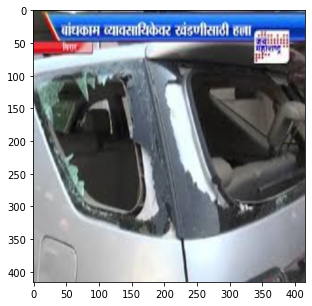

In [14]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

In [15]:
#Calculating time needed for forward pass
network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

print('YOLO v3 took {:.5f} seconds'.format(end-start))

YOLO v3 took 1.35208 seconds


In [16]:
print(type(output_from_network))
print(type(output_from_network[0]))

<class 'tuple'>
<class 'numpy.ndarray'>


In [17]:
np.random.seed(42)

colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')
print(colours.shape)
print(colours[0])

(80, 3)
[102 220 225]


In [18]:
bounding_boxes = []
confidences = []
class_numbers = []

In [19]:
h, w = image_input.shape[:2]
print(h, w)

168 300


In [20]:
for result in output_from_network:
    for detection in result:
        scores = detection[5:]
        class_current = np.argmax(scores)
        confidence_current = scores[class_current]
        if confidence_current > probability_minimum:
            box_current = detection[0:4] * np.array([w, h, w, h])
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width/2))
            y_min = int(y_center - (box_height/2))
            
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [21]:
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])

car
car


In [22]:
our_need_class = ['car', 'bus', 'truck', 'motorbike']
list_box = []
coordinates_need_object = []
class_object = []
if len(results) > 0:
    for i in results.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height), colour_box_current, 5)
        text_box_current = '{}:{:.4f}'.format(labels[int(class_numbers[i])], confidences[i])
        if labels[int(class_numbers[i])] in our_need_class:
            coordinates_need_object.append([x_min, y_min, x_min+box_width, y_min+box_height])
            class_object.append(text_box_current)
        else:
            pass
        
        cv2.putText(image_input, text_box_current, (x_min, y_min-7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 5)

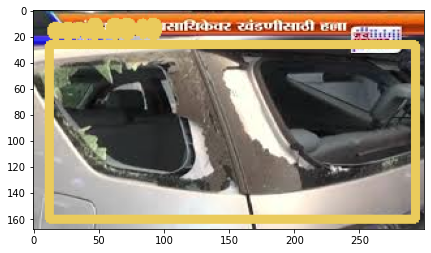

(168, 300, 3)


In [23]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
plt.imshow(image_input)
plt.show()
print(image_input.shape)

In [24]:
image_for_crop = Image.open('../input/car-damage-detection/data1a/training/00-damage/0079.JPEG')

At this picture we have: car:0.6949 
This has coordinates: [12, 26, 293, 160]


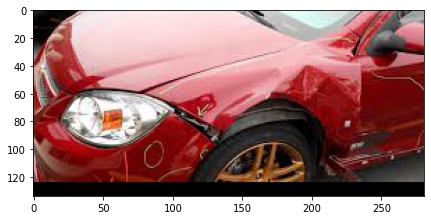

In [25]:
list_names_cut_objects = []
for i in range(len(class_object)):
    name_cut_object = f"Cut_object_{class_object[i]}.jpg"
    list_names_cut_objects.append(name_cut_object)
    im_crop = image_for_crop.crop((coordinates_need_object[i]))
    print(f"At this picture we have: {class_object[i]} \nThis has coordinates: {coordinates_need_object[i]}")
    im_crop.save(f'{name_cut_object}', quality=100)
    cut_image = Image.open(f'./{name_cut_object}')
    plt.imshow(cut_image)
    plt.show()

# **Cat and Dog Detection with YOLO v3**

In [26]:
 labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [27]:
print(layers_names_all)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [28]:
print(layers_names_output)

['yolo_82', 'yolo_94', 'yolo_106']


In [29]:
image_input_1 = cv2.imread("../input/images-for-testing/cat1.jpg")

In [30]:
image_input_shape_1 = image_input_1.shape
print(image_input_shape_1)

(2400, 3840, 3)


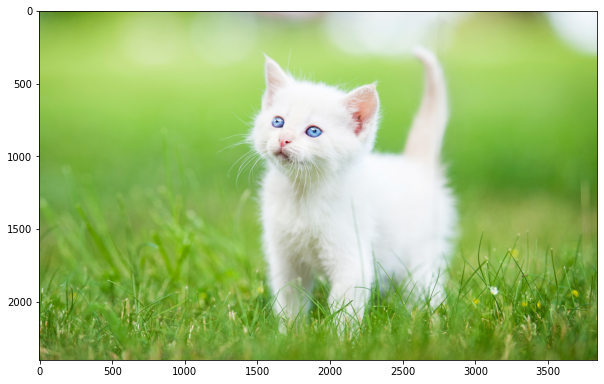

In [31]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input_1, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
blob = cv2.dnn.blobFromImage(image_input_1, 1/255.0, (416, 416), swapRB=True, crop=False)
print(image_input_1.shape)
print(blob.shape)

(2400, 3840, 3)
(1, 3, 416, 416)


In [33]:
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)

(416, 416, 3)


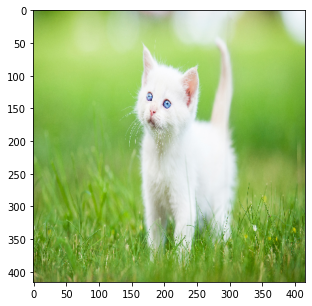

In [34]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

In [35]:
network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

print('YOLO v3 took {:.5f} seconds'.format(end-start))

YOLO v3 took 0.96206 seconds


In [36]:
print(type(output_from_network))
print(type(output_from_network[1]))

<class 'tuple'>
<class 'numpy.ndarray'>


In [37]:
np.random.seed(42)

colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

print(colours.shape)
print(colours[0])

(80, 3)
[102 220 225]


In [38]:
bounding_boxes = []
confidences = []
class_numbers = []


In [39]:
h, w = image_input_shape_1[:2]
print(h, w)

2400 3840


In [41]:
for result in output_from_network:
    for detection in result:
        scores = detection[5:]
        class_current = np.argmax(scores)  
        confidence_current = scores[class_current]
        if confidence_current > probability_minimum:
            box_current = detection[0:4] * np.array([w, h, w, h])
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width/2))
            y_min = int(y_center - (box_height/2))
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [42]:
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])
    
with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])

dog


In [43]:
if len(results) > 0:
    for i in results.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]
        cv2.rectangle(image_input, (x_min, y_min), (x_min+box_width, y_min+box_height), colour_box_current, 5)
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])
        cv2.putText(image_input_1, text_box_current, (x_min, y_min-7), cv2.FONT_HERSHEY_SIMPLEX, 1.5, colour_box_current, 5)

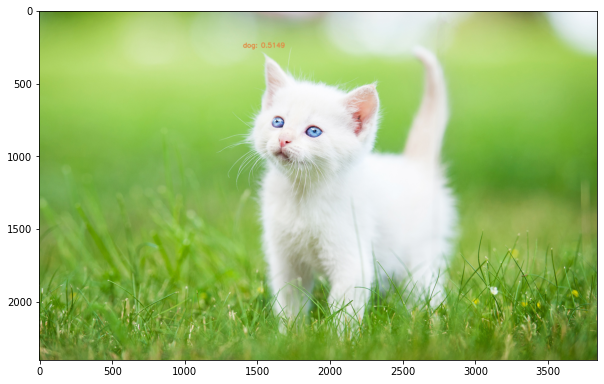

In [44]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input_1, cv2.COLOR_BGR2RGB))
plt.show()